# medMorphoBin - First project computer vision
## Discretization of the arterial structure.

- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

repository link: https://github.com/bl33h/medMorphoBin

In [1]:
# librerias
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import skeletonize
import networkx as nx
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.graph import route_through_array
import json

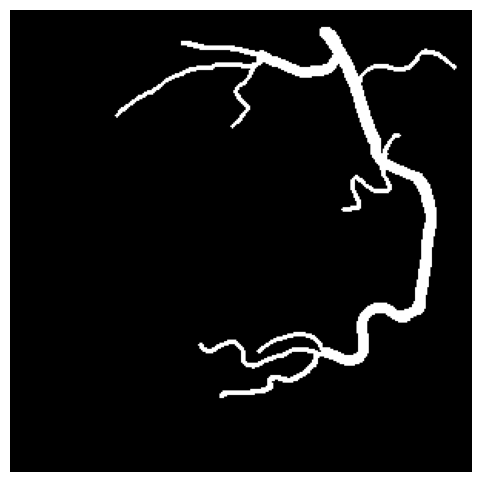

In [2]:
image_path = "img/7_gt.pgm"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Mostrar la imagen
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

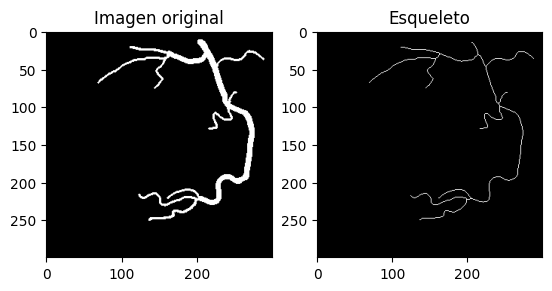

In [3]:
# otsu thresholding
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

skeleton = skeletonize(binary)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Esqueleto")
plt.imshow(skeleton, cmap='gray')

plt.show()

# coordenadas del esqueleto
skeleton_coords = np.column_stack(np.where(skeleton == 1))

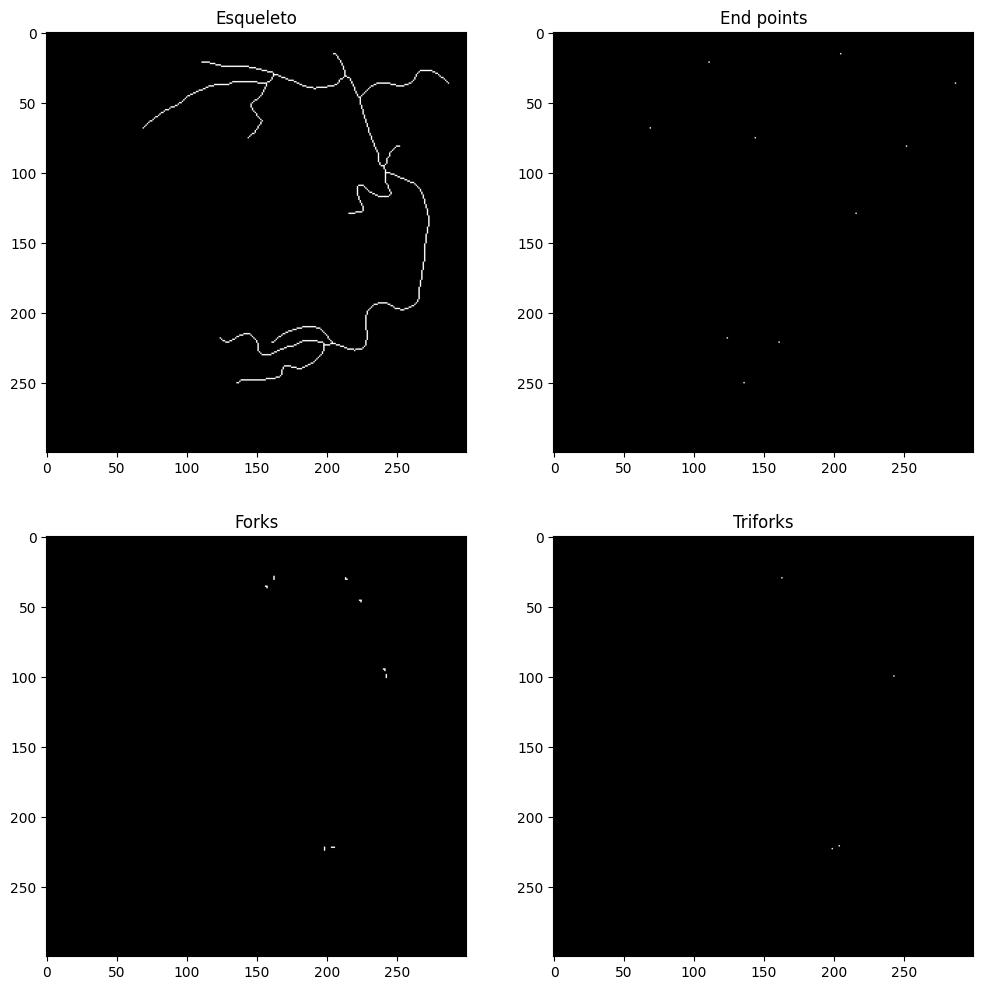

In [4]:
# Define the skeleton image (replace this with your actual skeleton image)
# skeleton = ...

# Define a kernel to count the number of neighbors
neighbor_kernel = np.array([[1, 1, 1],
                            [1, 10, 1],
                            [1, 1, 1]])

# Convolve the skeleton with the neighbor kernel
neighbor_count = convolve(skeleton.astype(np.uint8), neighbor_kernel, mode='constant', cval=0)

# Endpoints are pixels with exactly one neighbor (neighbor count == 11)
end_points = (neighbor_count == 11).astype(np.uint8)

# Forks are pixels with three or more neighbors (neighbor count >= 13)
fork_points = (neighbor_count == 13).astype(np.uint8)

# Triforks are pixels with exactly three neighbors (neighbor count == 13)
trifork_points = (neighbor_count >= 14).astype(np.uint8)

# Plot the results
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Esqueleto")
plt.imshow(skeleton, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("End points")
plt.imshow(end_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.subplot(2, 2, 3)
plt.title("Forks")
plt.imshow(fork_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.subplot(2, 2, 4)
plt.title("Triforks")
plt.imshow(trifork_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.show()

In [5]:
# obtener las coordenadas de los puntos finales, bifurcaciones y trifurcaciones
end_coords = np.column_stack(np.where(end_points == 1))
fork_coords = np.column_stack(np.where(fork_points == 1))
trifork_coords = np.column_stack(np.where(trifork_points == 1))

# filtrar las bifurcaciones que son trifurcaciones
for fork in fork_coords:
    for trifork in trifork_coords:
        if np.linalg.norm(fork - trifork) < 2:
            fork_coords = np.delete(fork_coords, np.where((fork_coords == fork).all(axis=1)), axis=0)
            break

In [6]:
# detectar nodos intermedios
intermediate_coords = []
for coord in skeleton_coords:
    if not any(np.array_equal(coord, end) for end in end_coords) and \
        not any(np.array_equal(coord, fork) for fork in fork_coords) and \
        not any(np.array_equal(coord, trifork) for trifork in trifork_coords):
        intermediate_coords.append(coord)

# aristas
edges = []
all_coords = np.vstack((end_coords, fork_coords, trifork_coords, intermediate_coords))
for i, coord1 in enumerate(all_coords):
    for j, coord2 in enumerate(all_coords):
        if i < j:
            if np.linalg.norm(coord1 - coord2) < 2:  # umbral de distancia, ajustable
                edges.append([coord1.tolist(), coord2.tolist()])

# Asegurarse de que todas las coordenadas estén en formato lista
end_coords = end_coords.tolist()
fork_coords = fork_coords.tolist()
trifork_coords = trifork_coords.tolist()
intermediate_coords = [coord.tolist() for coord in intermediate_coords]  # Convertir a lista

points_dict = {
    "end_points": end_coords,
    "fork_points": fork_coords,
    "trifork_points": trifork_coords,
    "intermediate_points": intermediate_coords,
    "edges": edges
}

# Guardar el diccionario en un archivo JSON
with open('outputs/points.json', 'w') as json_file:
    json.dump(points_dict, json_file, indent=4)

In [7]:
def find_neighbors(coord, skeleton):
    neighbors = []
    x, y = coord
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < skeleton.shape[0] and 0 <= ny < skeleton.shape[1]:
                if skeleton[nx, ny] == 1:
                    neighbors.append((nx, ny))
    return neighbors

In [8]:
G = nx.Graph()

for end in end_coords:
    G.add_node(tuple(end), node_type='end', color='green')

for fork in fork_coords:
    G.add_node(tuple(fork), node_type='fork', color='red')

for trifork in trifork_coords:
    G.add_node(tuple(trifork), node_type='trifork', color='blue')

for intermediate in intermediate_coords:
    G.add_node(tuple(intermediate), node_type='intermediate', color='gray')

all_coords = np.vstack((end_coords, fork_coords, trifork_coords))

for coord in skeleton_coords:
    neighbors = find_neighbors(coord, skeleton)
    for neighbor in neighbors:
        if neighbor in G.nodes:
            G.add_edge(tuple(coord), tuple(neighbor))

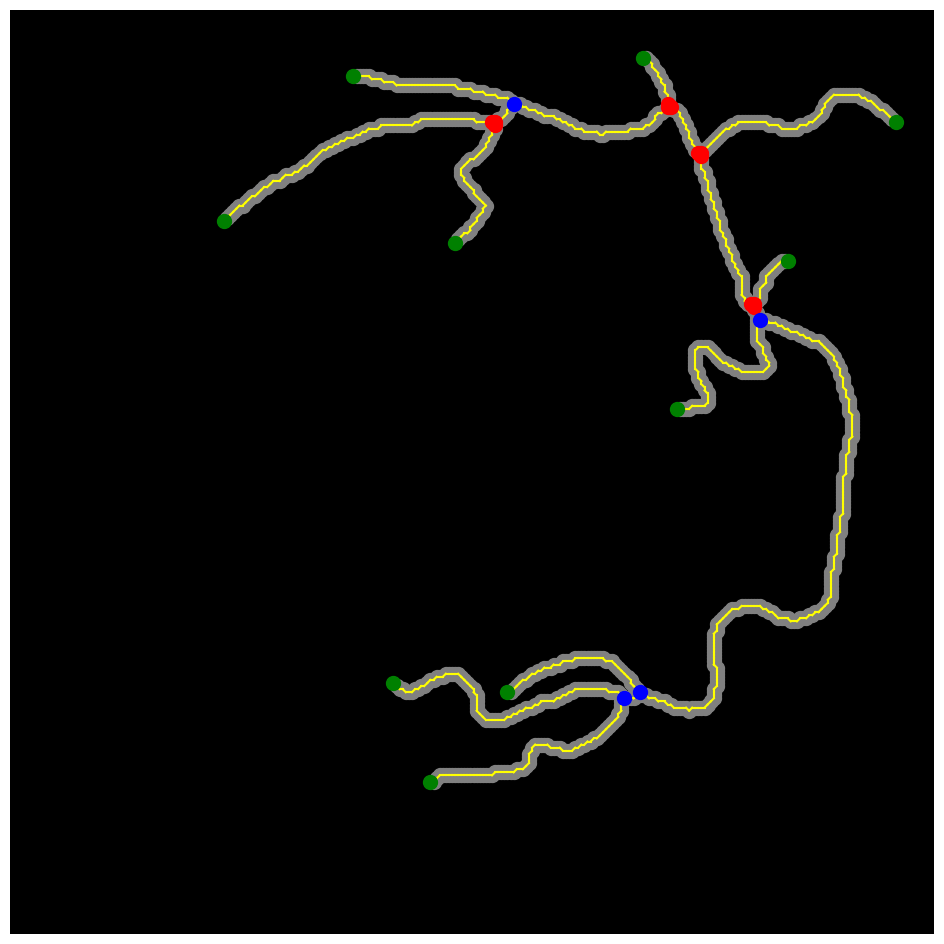

In [9]:
# Visualizar el grafo final sobre el esqueleto
plt.figure(figsize=(12, 12))
plt.imshow(skeleton, cmap='gray', zorder=0)
plt.axis('off')

# Plot de los nodos grises intermedios
for node in G.nodes(data=True):
    if node[1]['color'] == 'gray':
        plt.scatter(node[0][1], node[0][0], c=node[1]['color'], s=100, zorder=1)

# Plot de las aristas
for edge in G.edges(data=True):
    plt.plot([edge[0][1], edge[1][1]], [edge[0][0], edge[1][0]], 'yellow', zorder=2)

# Plot de los nodos de otros colores
for node in G.nodes(data=True):
    if node[1]['color'] != 'gray':
        plt.scatter(node[0][1], node[0][0], c=node[1]['color'], s=100, zorder=3)

# Guardar la visualización final
plt.savefig('outputs/final_graph.png')
plt.show()